# Heart Attack - Kaggle competition

Author: _Aniko Maraz, PhD_

<div class="alert alert-block alert-info">
    
This is an <a href="https://www.kaggle.com/competitions/heart-attack-risk-analysis/overview">active Kaggle competition</a>  for Kudos. <br>    
The task is to predict (on an unseen dataset) if the patient is at low or high risk of heart attack. The train data consists of 26 potential features. Luckily, the dataset contains no missing data or noteworthy outliers. <br>

In the current notebook I will preprocess the data, attempt to fit an XGBoost model (which performs better than SVM), and fine-tune the hyperparameters. The final model had an accuracy of 0.7541. Besides fine-tuning the parameters, feature selection also improved fit and left us with a nicely interpretable model. <br>

The first version of this model got me to place 56 in the competition. In this version I will try to improve the model and of course my place!

</div>

__Table of Contents__

![img](submission/toc.png)

## Imports

In [32]:
import numpy as np
import pandas as pd
from dataprep.eda import create_report

from matplotlib import pyplot as plt
import seaborn as sns

import statistics
from scipy.stats import uniform

# scikit-learn == 1.2.2 was installed

from sklearn.compose import make_column_selector
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer


from sklearn import set_config
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)

from xgboost import XGBClassifier, plot_importance

import jupyter_black
import warnings

%load_ext jupyter_black
%matplotlib inline

warnings.filterwarnings("ignore")  # for final notebook

# Display all columns in the DataFrame throughout the Notebook
pd.set_option("display.max_columns", None)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## DATA: GET AND EXPLORE

In [20]:
df_raw_train = pd.read_csv("data/train.csv")
df_raw_train.shape

(7010, 26)

Here is the first 5 rows of the data: 

In [21]:
df_raw_train.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,RDG0550,33,Male,200,129/90,48,0,1,1,1,1,7.807690,Unhealthy,0,1,2,0.138443,184066,30.449815,63,6,7,Argentina,South America,Southern Hemisphere,1
1,NMA3851,56,Female,262,159/105,46,1,0,1,0,0,17.297628,Average,1,0,8,0.369552,211755,34.973685,333,7,8,Nigeria,Africa,Northern Hemisphere,1
2,TUI5807,19,Female,140,161/109,54,0,1,0,0,1,8.695288,Average,1,1,3,8.646334,252203,30.554246,537,2,10,Thailand,Asia,Northern Hemisphere,0
3,YYT5016,50,Female,163,120/62,53,0,1,1,1,1,10.161587,Healthy,0,1,7,1.107884,121954,35.390265,591,0,9,Spain,Europe,Southern Hemisphere,1
4,ZAC5937,89,Female,144,153/110,92,1,0,1,0,1,16.436787,Healthy,1,0,1,1.337570,180121,39.575483,145,2,5,Germany,Europe,Northern Hemisphere,1


Let's see the data more in details (i.e. mean and distribution). 

In [22]:
report = create_report(df_raw_train)
# report.save('report_heart_attack')

  0%|                                                  | 0/3307 [00:00<?, ?it/s]

So. The EDA profiler tells us is that we have 26 variables (25 features + 1 target variable of low/high risk) and 7010 patients in rows. There is no missing data or duplicate rows, meaning each record is unique, which is great. We have 16 categorical and 9 numberical variables, plus a geo variable as a bonus (South/North hemisphere). 

Looking closer at the data, there seem to be 2 distinct type of measures / features: 
1. __biomarkers__ such as Blood Pressure, Family History, Diabetes, Previous Heart Problems and partially Medication Use, AND
2. __behavioural indicatiors__ such as Smoking, Obesity, Alcohol Consumption and Physical Activity (Days per week)

The mean __age__ is 54 years with a standard deviation of 21 years, and a range of 18-90, which nicely covers the general population characteristics. In terms of __sex__ about two-thirds are men, the rest is female. 

Mean __Cholesterol__ levels are at 260, which is above the normal value of 240, although this measure has a high variability (standard deviation = 81) and an almost bimodal distribution (values centering at 250 and 355 with a "valley" at 320). __Blood Pressure__ has to be mined, as the format is currently not suitable for analysis (i.e. 159/105). The mean of __Heart Rate__ is around 75 (std: 21, 40-110) which is again in the normal range. Noteworty is the bimodal distribution of this measure, with centers around 50 and 70 (valley at 72). 
__Diabetes__ is represented as a bivariate measure, with about 2/3rds of the sample having diabetes. __Family History__, __Obesity__ and __Previous Heart Problems__ each take two values, about half of the participants being obese, having previously heart problems, and also half reporting positive value for heart attack in the family. A suprisingly large proportion, about 90% of the sample report __Smoking__. Most of them (65%) reports __Alcohol Consumption__. After such high proportions of "unhealthy behaviour" the patients suprisingly report a mean __Exercise__ of 10 hours per week (std: 5.8, 0-20 hrs). In terms of __Diet__, there are equal proportions of Health, Average and Unhealth dieters. Although there is no information on which kind of __Medication__ patients take, half of them report using. __Stress Levels__ are approximately equally distributed among 10 possible categories. __Income__ centers around 158.000 USD a year, which indicates the sample being well, pretty rich - over twice as high than the average yearly salary in 2023. __BMI__ may also be an important indicator: the mean is 29, with a standard deviation of 6.3 indicating general population levels. In terms of __Triglycerides__, the mean is around 416 (data are approximately equally distributed between 30 and 800), which indicates high levels compared to the normal being less than 150mg/dL. __Physical Activity__ ranges equally between 0 and 7 days a week as well as __Sleep Hours Per Day__ (ranging between 4 and 10 but in almost fully equal proportions in the sample, so no outliers). In terms of __Country__ most patients come from "Otherland", the rest being distributed accross the world and accross __Continents__ with Europe and Asia being the most represented. This also leads to the fact that most patients (about 70%) live on the Northern __Hemisphere__. Finally, our target variable: 35% has a high __risk for heart attack__, and 65% has low risk. 

In summary the data is of good quality with no missing or weird values, also no duplicates, each row is unique. However, given the probably artificial nature of the data, not all variables are expected to be associated with the target variable in this modeling given their uniform distribution. 




Looking at the distribution between variables, smoking is negatively associated with age (so young people are more likely to smoke). All other variables have a negligible association with each other. 

So now we have (7010, 29) (rows and columns) for the train data and  (1753, 28) rows and columns for testing. We don't have to worry about imputing the data, as this is a complete database. 

In [23]:
# drop Patient ID
df_raw_train = df_raw_train.drop(columns=["Patient ID"])

## PREPROCESSING PIPELINE

In [109]:
# def function to split blood pressure data (current format: 129/90)
def split_blood_pressure(df):
    df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic"] = pd.to_numeric(df["Systolic"])
    df["Diastolic"] = pd.to_numeric(df["Diastolic"])
    df.drop(columns=["Blood Pressure"], inplace=True)


# split cholesterol according to sample mean
cholesterol_sample_mean = df_raw_train["Cholesterol"].mean()


def split_cholesterol_sample(df):
    df["Cholesterol_sample_split"] = np.where(
        df["Cholesterol"] > cholesterol_sample_mean, 1, 0
    )


# total excercise
def exercise_total(df):
    df["Exercise Total"] = (
        df["Exercise Hours Per Week"] * df["Physical Activity Days Per Week"]
    )


def systolic_diastolic_ratio_constructor(df):
    df["Systolic_Diastolic_Ratio"] = df["Systolic"] / df["Diastolic"]


# preprocess TRAIN data
df = df_raw_train.copy()

split_blood_pressure(df=df)
split_cholesterol_sample(df=df)
exercise_total(df=df)
systolic_diastolic_ratio_constructor(df=df)

In [25]:
# Defining the features and the target
X = df.drop(columns="Heart Attack Risk")
y = df["Heart Attack Risk"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

# check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4907, 27), (2103, 27), (4907,), (2103,))

In [114]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Define the continuous and categorical variables
continuous_vars = [
    "Age",
    "Cholesterol",
    "Heart Rate",
    "Exercise Hours Per Week",
    "Sedentary Hours Per Day",
    "Income",
    "Stress Level",
    "BMI",
    "Triglycerides",
    "Sleep Hours Per Day",
    "Physical Activity Days Per Week",
    "Systolic",
    "Diastolic",
    "Exercise Total",
]

categorical_vars = ["Sex", "Hemisphere", "Country", "Continent", "Diet"]

# Define preprocessing steps for continuous and categorical features
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop="first")

preproc_basic = ColumnTransformer(
    transformers=[
        ("num", num_transformer, continuous_vars),
        ("cat", cat_transformer, categorical_vars),
    ],
    remainder="passthrough",
)

# Fit the preprocessing pipeline on the training data
X_train_preprocessed = preproc_basic.fit_transform(X_train)

# Display the preprocessed data shape
print(X_train_preprocessed.shape)

(4907, 47)


In [117]:
preproc_full

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cholesterol',
                                                   'Heart Rate',
                                                   'Exercise Hours Per Week',
                                                   'Sedentary Hours Per Day',
                                                   'Income', 'Stress Level',
                                                   'BMI', 'Triglycerides',
                                                   'Sleep Hours Per Day',
                                                   'Physical Activity Days Per '
                                                   'Week',
                                                   'Systolic', 'Diastolic',
                                                   'Exercise Total']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Hemisphere',
                                                   'Country', 'Continent',
                                                   'Diet'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<function dummying at 0x758e5eee9480>))])

In [118]:
pd.DataFrame(X_train_preprocessed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,-1.672237,-1.014593,1.454505,-0.897577,-1.682992,-1.392567,0.195541,0.798444,-1.612383,0.986796,0.657322,-0.988124,-0.905289,-0.332611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.513889
1,0.437659,1.131023,0.922030,0.459524,-0.803777,-0.817050,-1.200633,-0.227883,-1.434302,0.485532,-1.106922,-0.034026,0.186643,-0.673764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.522727
2,1.609824,1.661262,-1.159467,-0.395395,-1.033935,-0.346235,0.893629,-0.816309,-1.505534,0.986796,1.539444,-0.873633,-1.587747,0.572328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.806452
3,1.234731,-0.817295,-0.046108,0.883882,0.666210,0.454160,1.242672,1.293636,-1.719232,-1.519522,0.657322,1.301711,0.323135,1.227107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.877778
4,0.531432,-0.213069,-1.014246,1.430947,-0.876184,-1.236068,-0.502546,-0.581388,0.613633,-0.516995,-0.665861,0.156793,-0.154586,0.048773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.674699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,0.812752,0.822745,-0.675398,-0.298014,-0.853799,1.759690,-0.153502,-1.244651,1.530751,0.485532,-1.106922,-1.636911,0.937347,-0.806413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.929293
4903,-1.578464,0.600785,1.357692,-0.632617,0.667073,-1.334164,1.242672,1.157359,-0.405883,0.986796,0.216261,0.118629,-0.495815,-0.291724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.769231
4904,-1.250258,0.983050,0.341147,1.124741,-0.683378,0.605472,1.591716,0.171269,0.399935,-1.018259,1.539444,0.920072,-0.768798,2.435621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.148649
4905,-1.390918,-0.077427,-1.691943,1.447227,-0.147376,-0.670017,-0.851590,-1.606251,1.397190,0.485532,0.216261,-1.675075,0.323135,1.165047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.011111


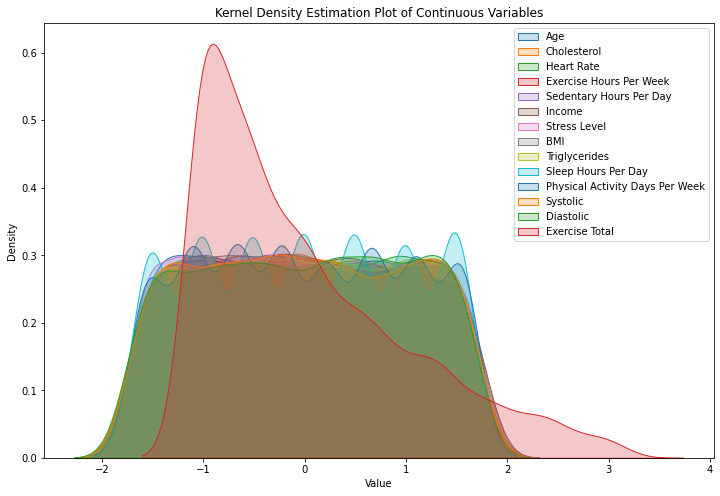

In [119]:
# Select only the continuous variables
continuous_data = X_train_preprocessed[:, :14]
continuous_df = pd.DataFrame(continuous_data, columns=continuous_vars)

# Plot KDE for each continuous variable
plt.figure(figsize=(12, 8))
for column in continuous_df.columns:
    sns.kdeplot(continuous_df[column], label=column, shade=True)

plt.title("Kernel Density Estimation Plot of Continuous Variables")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

### Baseline model

In [120]:
# Add estimator
pipeline_baseline = make_pipeline(
    preproc_full, LogisticRegression(solver="saga", max_iter=10000)
)

pipeline_baseline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'Cholesterol',
                                                                    'Heart '
                                                                    'Rate',
                                                                    'Exercise '
                                                                    'Hours Per '
                                                                    'Week',
                                                                    'Sedentary '
                                                                    'Hours Per '
                                                                    'Day',
                                                                    'Income',
                                                                    'Stress '
                                                                    'Level',
                                                                    'BMI',
                                                                    'Triglycerides',
                                                                    'Sleep '
                                                                    'Hours Per '
                                                                    'Day',
                                                                    'Physical '
                                                                    'Activity '
                                                                    'Days Per '
                                                                    'Week',
                                                                    'Systolic',
                                                                    'Diastolic',
                                                                    'Exercise '
                                                                    'Total']),
                                                                  ('cat',
                                                                   OneHotEncoder(),
                                                                   ['Sex',
                                                                    'Hemisphere',
                                                                    'Country',
                                                                    'Continent',
                                                                    'Diet'])])),
                                 ('functiontransformer',
                                  FunctionTransformer(func=<function dummying at 0x758e5eee9480>))])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, solver='saga'))])

In [121]:
# Train Pipeline
pipeline_baseline.fit(X_train, y_train)

# Score model
pipeline_baseline.score(X_test, y_test)

# Cross-validate Pipeline
cross_val_score(pipeline_baseline, X_train, y_train, cv=5, scoring="accuracy").mean()

ValueError: Shape of passed values is (4907, 52), indices imply (4907, 19)

### XGBoost

In [45]:
# Add estimator
pipeline_xgboost = make_pipeline(
    preproc_full,
    XGBClassifier(
        subsample=1.0,
        scale_pos_weight=1,
        reg_lambda=2,
        reg_alpha=1,
        gamma=0,
        colsample_bytree=0.1,
        max_depth=10,
        n_estimators=200,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=8,
    ),
)

pipeline_xgboost

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('columntransformer',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('pipeline',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer()),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Cholesterol',
                                                                                   'Heart '
                                                                                   'Rate',
                                                                                   'Exercise '
                                                                                   'Hours '
                                                                                   'Per '
                                                                                   'Week',
                                                                                   'Sedentary '
                                                                                   'Hours '
                                                                                   'Per '
                                                                                   'Day',
                                                                                   'Income',
                                                                                   'Stress '...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=8,
                               num_parallel_tree=None, random_state=None, ...))])

In [46]:
# Train Pipeline
pipeline_xgboost.fit(X_train, y_train)

# Score model
pipeline_xgboost.score(X_test, y_test)

# Cross-validate Pipeline
cross_val_score(pipeline_xgboost, X_train, y_train, cv=5, scoring="accuracy").mean()

0.6154443593241029

In [91]:
# pipeline_xgboost.get_params()

{'memory': None,
 'steps': [('featureunion',
   FeatureUnion(transformer_list=[('columntransformer',
                                   ColumnTransformer(remainder='passthrough',
                                                     transformers=[('pipeline',
                                                                    Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer()),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                                    ['Age',
                                                                     'Cholesterol',
                                                                     'Heart Rate',
                                                                     'Exercise '
   

In [44]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline_xgboost,
    param_grid={
        # Access any component of the Pipeline
        # and any available hyperparamater you want to optimize
        
            'xgbclassifier__n_estimators': [50, 100],
            'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3],  # eta
            'xgbclassifier__max_depth': [3, 5, 7, 10],
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
             'xgbclassifier__gamma': [0.6, 0.8, 1.0],
            'xgbclassifier__subsample': [0, 0.1, 0.2, 0.3],
            'xgbclassifier__reg_alpha': [0, 0.01, 0.1, 1],
             'xgbclassifier__reg_lambda': [1, 1.5, 2, 3],
    },
    cv=5,
    scoring="accuracy",
    n_jobs = 8, 
    verbose = 1
)


grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 18432 candidates, totalling 92160 fits


KeyboardInterrupt: 

In [78]:
# save the pipelined model with the best hyperparameters
pipeline_tuned = grid_search.best_estimator_
pipeline_tuned

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('columntransformer',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('pipeline',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer()),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Cholesterol',
                                                                                   'Heart '
                                                                                   'Rate',
                                                                                   'Exercise '
                                                                                   'Hours '
                                                                                   'Per '
                                                                                   'Week',
                                                                                   'Sedentary '
                                                                                   'Hours '
                                                                                   'Per '
                                                                                   'Day',
                                                                                   'Income',
                                                                                   'Stress '...
                                                                                   'Day',
                                                                                   'Physical '
                                                                                   'Activity '
                                                                                   'Days '
                                                                                   'Per '
                                                                                   'Week',
                                                                                   'Systolic',
                                                                                   'Diastolic',
                                                                                   'Exercise '
                                                                                   'Total']),
                                                                                 ('onehotencoder',
                                                                                  OneHotEncoder(),
                                                                                  ['Sex',
                                                                                   'Hemisphere',
                                                                                   'Country',
                                                                                   'Continent',
                                                                                   'Diet'])])),
                                                ('functiontransformer',
                                                 FunctionTransformer(func=<function <lambda> at 0x7c35285830a0>))])),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    solv

## PREDICT

In [79]:
pipeline_tuned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_train_transformed = preproc_full.fit_transform(X_train)

print("Original training set")
display(X_train.head(3))

print("Preprocessed training set")
display(
    pd.DataFrame(
        X_train_transformed, columns=preproc_full.get_feature_names_out()
    ).head()
)

## Evaluation on Kaggle